# Optimized+augmented PyTorch RGB CNN

In this notebook, we train the winning CNN architecture from the Optuna run in notebook 04 on the CIFAR-10 dataset with image augmentation for improved generalization.

## Notebook set-up

### Imports

In [1]:
# Standard library imports
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import numpy as np
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Package imports
from image_classification_tools.pytorch.data import make_data_loaders, generate_augmented_data
from image_classification_tools.pytorch.evaluation import evaluate_model
from image_classification_tools.pytorch.hyperparameter_optimization import create_cnn
from image_classification_tools.pytorch.plotting import (
    plot_sample_images, plot_learning_curves, 
    plot_confusion_matrix, plot_class_probability_distributions,
    plot_evaluation_curves
)

from image_classification_tools.pytorch.training import train_model

### Configuration

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(315)
np.random.seed(315)

# Check for GPU availability
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Image data directory
data_dir = data_dir = Path('../data/pytorch/cifar10')

# Data augmentation
force_reaugment = False # Set to True to force regeneration of augmented data even if saved data exists
augmented_data_path = '../data/pytorch/cifar10_augmented/augmented_train_data.pt' # Path to save/load augmented data
Path(augmented_data_path).parent.mkdir(parents=True, exist_ok=True)

# Optuna study storage
storage_path = Path('../data/pytorch/cnn_optimization.db')
storage_url = f'sqlite:///{storage_path}'

# Suppress Optuna info messages
optuna.logging.set_verbosity(optuna.logging.WARNING)

# CIFAR-10 class names in class order
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

num_classes = len(class_names)

Using device: cuda:1


### Hyperparameters

In [ ]:
# Split sizes
val_size = 1500
test_size = 1500

# Data augmentation
augmentations_per_image = 3

# Training
epochs = 100
print_every = 5

## 1. Load optimization results

In [4]:
# Get optimization results from disk
study = optuna.load_study(
    study_name='cnn_optimization',
    storage=storage_url
)

# Extract hyperparameters from winning trial
best_params = study.best_trial.params
batch_size = best_params['batch_size']

print('Loaded best hyperparameters from Optuna study:')

for key, value in best_params.items():
    print(f'  {key}: {value}')

print(f'\nBest validation accuracy from optimization: {study.best_trial.value:.2f}%')
print(f'Using batch size: {batch_size}')

Loaded best hyperparameters from Optuna study:
  batch_size: 128
  n_conv_blocks: 5
  initial_filters: 32
  n_fc_layers: 3
  conv_dropout_rate: 0.20580826181444656
  fc_dropout_rate: 0.6256974158954143
  learning_rate: 0.009953740074287116
  optimizer: SGD
  weight_decay: 7.447212265757987e-05
  sgd_momentum: 0.8603419917972446

Best validation accuracy from optimization: 86.53%
Using batch size: 128


## 1. Load and preprocess CIFAR-10 data

Load the images into PyTorch tensors and split them into training, validation and testing datasets as before, but this time generate an augmented dataset and store it on disk.

### 1.1. Define preprocessing transforms

In [5]:
# Define transform (RGB)
input_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

### 1.2. Load the data

In [6]:
dataset = datasets.CIFAR10(
    root=data_dir,
    train=True,
    download=False,
    transform=input_transform
)

### 1.3. Take a look at some images

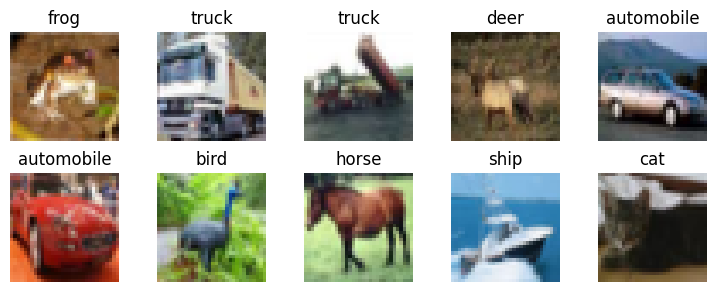

In [7]:
# Plot first 10 images from the training dataset
fig, axes = plot_sample_images(dataset, class_names)
plt.show()

### 1.4. Training, validation and testing split

In [ ]:
# Convert dataset to a single tensor for images and labels
X = torch.stack([img for img, _ in dataset]).to(device)
y = torch.tensor([label for _, label in dataset]).to(device)

# Split data into train, validation, and test sets
train_size = len(X) - val_size - test_size

indices = torch.randperm(len(X))

X_train = X[indices[:train_size]]
y_train = y[indices[:train_size]]
X_val = X[indices[train_size:train_size + val_size]]
y_val = y[indices[train_size:train_size + val_size]]
X_test = X[indices[train_size + val_size:]]
y_test = y[indices[train_size + val_size:]]

print(f'Train set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Train set size: 47000
Validation set size: 1500
Test set size: 1500


### 1.5. Data augmentation

In [9]:
# Define augmentation transforms (applied to already normalized tensors)
augmentation_transforms = nn.Sequential(
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomRotation(degrees=15)], p=0.1),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)], p=0.1),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))], p=0.1),
    transforms.RandomGrayscale(p=0.1),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
    transforms.RandomApply([transforms.Lambda(lambda x: -x)], p=0.1),  # Color inversion (negative)
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, torch.randperm(3)])], p=0.3),  # Shuffle RGB channels
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 0].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate R channel
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 1].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate G channel
    transforms.RandomApply([transforms.Lambda(lambda x: x[:, 2].unsqueeze(1).repeat(1, 3, 1, 1))], p=0.1),  # Duplicate B channel
)

In [10]:
# Generate augmented training dataset and save to disk
X_train_final, y_train_final = generate_augmented_data(
    X_train=X_train,
    y_train=y_train,
    augmentation_transforms=augmentation_transforms,
    augmentations_per_image=augmentations_per_image,
    save_path=augmented_data_path,
    force_reaugment=force_reaugment
)

Loading pre-generated augmented data from ../data/pytorch/cifar10_augmented/augmented_train_data.pt...

Loaded augmented training set:
  Total size: 188000
  Original: 47000
  Added: 141000
  Memory location: cpu
  Augmentation factor: 4.0x


### 1.6 Create dataloaders

In [ ]:
# Create TensorDatasets for train, validation, and test sets
train_tensor_dataset = torch.utils.data.TensorDataset(X_train_final, y_train_final)
val_tensor_dataset = torch.utils.data.TensorDataset(X_val, y_val)
test_tensor_dataset = torch.utils.data.TensorDataset(X_test, y_test)

# Finally, create DataLoaders
train_loader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_tensor_dataset, batch_size=batch_size)
test_loader = DataLoader(test_tensor_dataset, batch_size=batch_size)

print(f'X_train_final shape: {X_train_final.shape}')
print(f'y_train_final shape: {y_train_final.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

print(f'\nTraining data on: {X_train_final.device}')
print(f'Validation data on: {X_val.device}')
print(f'Test data on: {X_test.device}')

X_train_final shape: torch.Size([188000, 3, 32, 32])
y_train_final shape: torch.Size([188000])
X_val shape: torch.Size([1500, 3, 32, 32])
y_val shape: torch.Size([1500])
X_test shape: torch.Size([1500, 3, 32, 32])
y_test shape: torch.Size([1500])

Training data on: cpu
Validation data on: cuda:1
Test data on: cuda:1


## 2. Build optimized CNN using best hyperparameters

Create a CNN using the best hyperparameters found during Optuna optimization, then train it with data augmentation.

### 2.2. Create model with best hyperparameters

In [12]:
# Create model with best hyperparameters from Optuna
model = create_cnn(
    n_conv_blocks=best_params['n_conv_blocks'],
    initial_filters=best_params['initial_filters'],
    n_fc_layers=best_params['n_fc_layers'],
    conv_dropout_rate=best_params['conv_dropout_rate'],
    fc_dropout_rate=best_params['fc_dropout_rate'],
    num_classes=num_classes,
    in_channels=3
).to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(model)
print(f'\nTotal parameters: {trainable_params:,}')

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.20580826181444656, inplace=False)
  (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU()
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (15): Dropout(p=0.20580826181444656, inplace=False)
  (16): Conv2d(64

### 2.3. Define loss function and optimizer

In [13]:
criterion = nn.CrossEntropyLoss()

# Create optimizer with best hyperparameters
if best_params['optimizer'] == 'Adam':
    optimizer = optim.Adam(
        model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

elif best_params['optimizer'] == 'SGD':
    optimizer = optim.SGD(
        model.parameters(), 
        lr=best_params['learning_rate'],
        momentum=best_params.get('sgd_momentum', 0.9),
        weight_decay=best_params['weight_decay']
    )

else:  # RMSprop
    optimizer = optim.RMSprop(
        model.parameters(), 
        lr=best_params['learning_rate'],
        weight_decay=best_params['weight_decay']
    )

print(f"Optimizer: {best_params['optimizer']}")

Optimizer: SGD


### 2.4. Train model

In [14]:
%%time

history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    lazy_loading=True,  # Training data on CPU, moved to GPU per batch
    epochs=epochs,
    print_every=print_every
)

print()

Epoch   1/100 - loss: 2.0059 - acc: 19.58% - val_loss: 1.7512 - val_acc: 28.53% - lr: 9.95e-03 (base: 9.95e-03, max: 9.95e-03)
Epoch   5/100 - loss: 1.1191 - acc: 63.54% - val_loss: 0.7192 - val_acc: 74.07% - lr: 9.95e-03 (base: 9.95e-03, max: 9.95e-03)
Epoch  10/100 - loss: 0.8267 - acc: 74.85% - val_loss: 0.5240 - val_acc: 83.53% - lr: 9.95e-03 (base: 9.95e-03, max: 9.95e-03)
Epoch  15/100 - loss: 0.6828 - acc: 79.55% - val_loss: 0.4995 - val_acc: 85.53% - lr: 9.95e-03 (base: 9.95e-03, max: 9.95e-03)
Epoch  20/100 - loss: 0.5930 - acc: 82.47% - val_loss: 0.4417 - val_acc: 87.20% - lr: 9.95e-03 (base: 9.95e-03, max: 9.95e-03)
Epoch  25/100 - loss: 0.5333 - acc: 84.42% - val_loss: 0.3973 - val_acc: 87.53% - lr: 9.95e-03 (base: 9.95e-03, max: 9.95e-03)
Epoch  30/100 - loss: 0.4861 - acc: 85.83% - val_loss: 0.4021 - val_acc: 87.40% - lr: 9.95e-03 (base: 9.95e-03, max: 9.95e-03)

Early stopping at epoch 33
Best val_loss: 0.3933 at epoch 23
Restored best model weights

CPU times: user 26mi

### 2.5. Learning curves

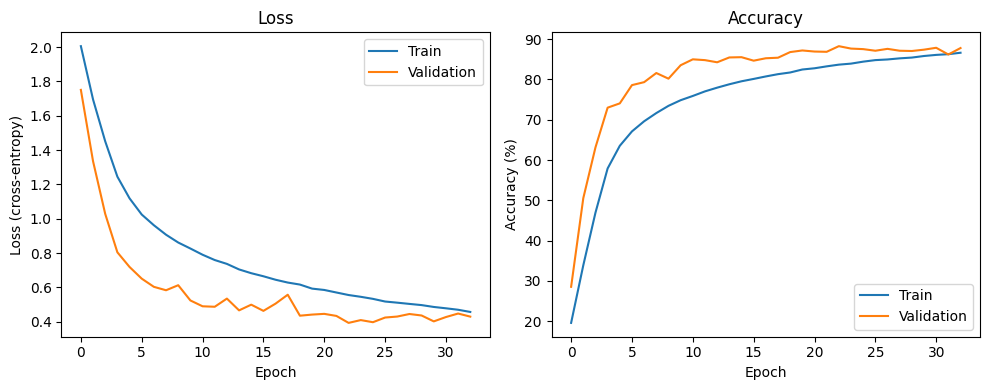

In [15]:
fig, axes = plot_learning_curves(history)
plt.show()

## 3. Evaluate model on test set

### 3.1. Calculate test accuracy

In [16]:
# Custom evaluation with per-batch GPU transfer
model.eval()
predictions = []
true_labels = []
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()
        
        predictions.extend(predicted.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

test_accuracy = 100 * test_correct / test_total
print(f'Test accuracy: {test_accuracy:.2f}%')

Test accuracy: 88.13%


### 3.2. Per-class accuracy

In [17]:
# Calculate per-class accuracy
class_correct = {name: 0 for name in class_names}
class_total = {name: 0 for name in class_names}

for pred, true in zip(predictions, true_labels):

    class_name = class_names[true]
    class_total[class_name] += 1

    if pred == true:
        class_correct[class_name] += 1

print('Per-class accuracy:')
print('-' * 30)

for name in class_names:
    acc = 100 * class_correct[name] / class_total[name]
    print(f'{name:12s}: {acc:.2f}%')

Per-class accuracy:
------------------------------
airplane    : 88.34%
automobile  : 94.77%
bird        : 75.66%
cat         : 77.69%
deer        : 84.72%
dog         : 80.26%
frog        : 92.72%
horse       : 93.29%
ship        : 97.78%
truck       : 94.87%


### 3.3. Confusion matrix

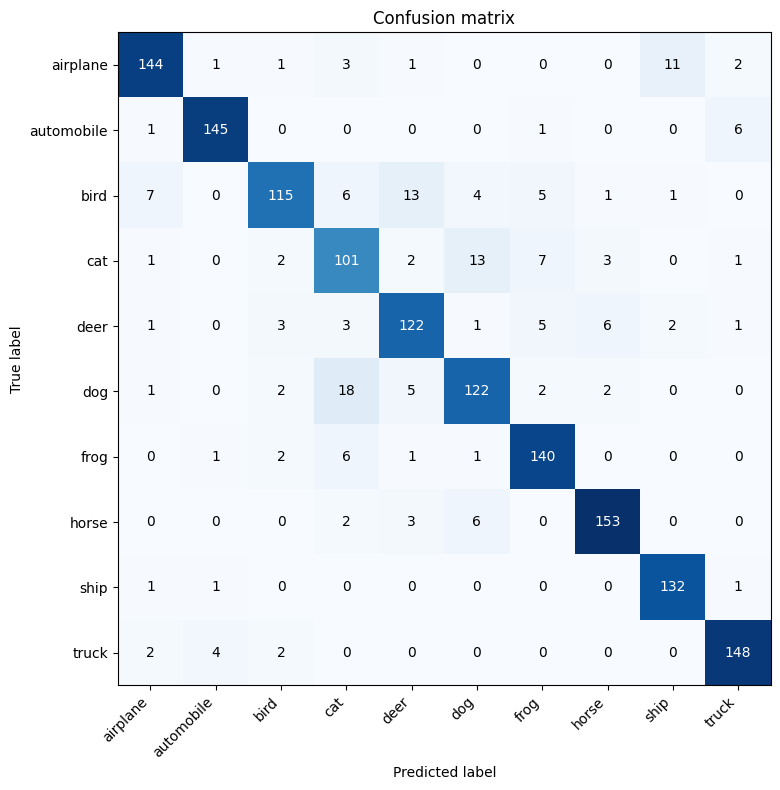

In [18]:
fig, ax = plot_confusion_matrix(true_labels, predictions, class_names)
plt.show()

### 3.4. Predicted class probability distributions

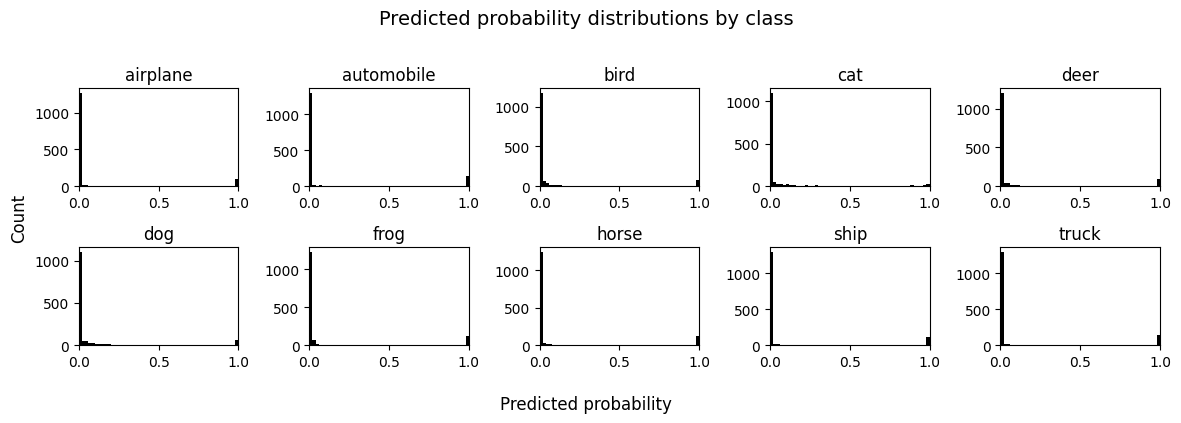

In [19]:
# Get predicted probabilities for all test samples
model.eval()
all_probs = []

with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device, non_blocking=True)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        all_probs.append(probs.cpu().numpy())

all_probs = np.concatenate(all_probs, axis=0)

# Plot probability distributions
fig, axes = plot_class_probability_distributions(all_probs, class_names)
plt.show()

### 3.5. Evaluation curves

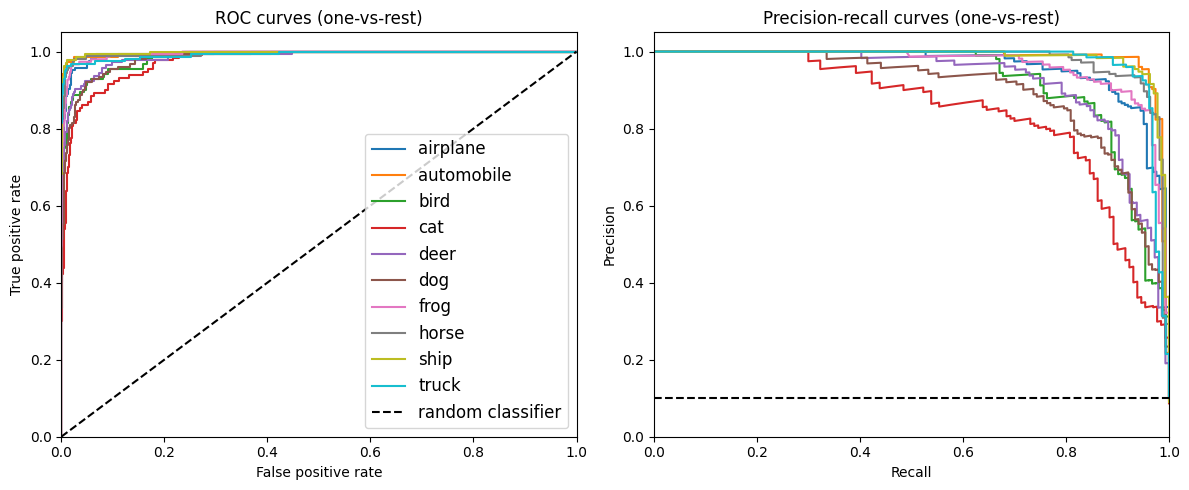

In [20]:
fig, (ax1, ax2) = plot_evaluation_curves(true_labels, all_probs, class_names)
plt.show()

## 4. Save model

In [21]:
# Create models directory if it doesn't exist
models_dir = Path('../models/pytorch')
models_dir.mkdir(parents=True, exist_ok=True)

# Save model state dict
model_path = models_dir / 'augmented_cnn.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'test_accuracy': test_accuracy,
    'history': history
}, model_path)

print(f'Model saved to: {model_path}')
print(f'Test accuracy: {test_accuracy:.2f}%')

Model saved to: ../models/pytorch/augmented_cnn.pth
Test accuracy: 88.13%
